# Run simulations with O'Regan 2021 parameter set (LG M50)

In this notebook we show an example on how to run the DFN model with the O'Regan 2021 parameter set for the LG M50 cell. Because of the concentration dependent diffusion coefficient, we need to customise the mesh so the simulations converge.

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm

You should consider upgrading via the '/home/ferranbrosa/PyBaMM/.tox/dev/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


We first initialise the model and define the parameter set and the solver:

In [2]:
# DFN + lumped thermal
options = {"thermal": "lumped", "dimensionality": 0, "cell geometry": "arbitrary"}
model = pybamm.lithium_ion.DFN(options=options)

# O'Regan 2021 parameter set
param = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.ORegan2021)

# Choose CasADI fast (we do a short discharge so there are no events, if events are needed choose "fast with events")
solver = pybamm.CasadiSolver(mode="fast")

Now we define the new mesh. Because the particle diffusivity depends on concentration and get drop very abruptly, we set a very fine mesh (150 points in each particle). Additionally, given that the larger gradients occur towards the particle surface, we choose an exponential mesh weighted towards the `right` (i.e. the particle surface). This generates a non-uniform mesh with a finer grid towards the particle surface and a coarser grid towards the particle centre.

In [3]:
var = pybamm.standard_spatial_vars
var_pts = {var.x_n: 30, var.x_s: 30, var.x_p: 30, var.r_n: 150, var.r_p: 150}

submesh_types = model.default_submesh_types
submesh_types["negative particle"] = pybamm.MeshGenerator(
    pybamm.Exponential1DSubMesh, submesh_params={"side": "right"}
)
submesh_types["positive particle"] = pybamm.MeshGenerator(
    pybamm.Exponential1DSubMesh, submesh_params={"side": "right"}
)

# Define the simulation
sim = pybamm.Simulation(
    model,
    parameter_values=param,
    C_rate=1,
    solver=solver,
    var_pts=var_pts,
    submesh_types=submesh_types,
)

Finally, we can solve the simulation and plot the results. Note that because the nonlinear diffusion and the fine mesh, if we want to solve for longer time, such as full discharge or other experiments, the simulations might take a few minutes to run.

interactive(children=(FloatSlider(value=0.0, description='t', max=9.999999999999998, step=0.09999999999999998)…

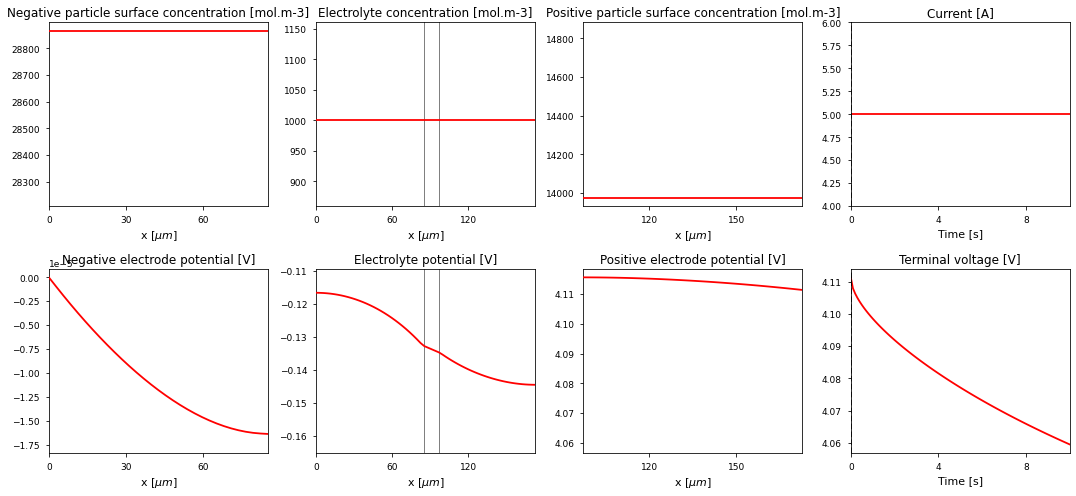

In [4]:
sim.solve([0, 10])    # solving time kept short for testing purposes, feel free to extend it
sim.plot()

In [5]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[3] Marc Doyle, Thomas F. Fuller, and John Newman. Modeling of galvanostatic charge and discharge of the lithium/polymer/insertion cell. Journal of the Electrochemical society, 140(6):1526–1533, 1993. doi:10.1149/1.2221597.
[4] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with